In [ ]:
%pip install git+https://github.com/mauricef/halite-iv-jax.git@9e04bec18a5b45deb3e1828b277115365318b914 \
    seaborn \
    dm-haiku \
    optax \
    kaggle-environments

In [3]:
%pip install -e ..

Obtaining file:///Users/maurice/Code/mauricef.github.io/halite
  Running setup.py develop for halite-iv-jax
Note: you may need to restart the kernel to use updated packages.


In [1]:
%load_ext autoreload
%autoreload 2

# Predict Simple Agent
Predict action and value for simple agent that follows some simple rules selecting it's next action. 

In [1]:
import copy
from collections import namedtuple
import haiku as hk
from jax import random, jit, partial, vmap, value_and_grad, grad, lax, ops, nn
import jax.numpy as np
import jax.nn as nn
from jax.scipy.signal import correlate
from jax.scipy.special import logit, expit
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
import optax
import pandas as pd
import seaborn as sns

from halite_jax import State, Cell, Episode, Trajectory
from halite_jax import tree_index, tree_batch
from halite_jax import net_present_value
from halite_jax import generate_episode
from halite_jax import Action
from halite_jax import make_config
from halite_jax import render_episode, render_state
from halite_jax import vmap_random
rng = random.PRNGKey(42)

Loading environment football failed: No module named 'gfootball'


In [2]:
def random_mask(rng, shape, count, filter_mask=None):
    filter_mask = filter_mask if filter_mask is not None else np.array(np.zeros(shape), bool)
    filter_mask = np.ravel(filter_mask)
    mask = random.uniform(rng, shape=filter_mask.shape)
    mask = np.where(filter_mask, np.inf, mask)
    mask = mask < np.sort(mask)[count]
    mask = np.reshape(mask, shape)
    return mask

def generate_manhattan_distances(size):
    a = np.abs(np.arange(size) - size // 2)
    return a + a[:, None]

def generate_smoothing_kernel(kernel_size, discount=.5):
    center = kernel_size // 2
    distances = generate_manhattan_distances(kernel_size)
    return np.power(discount, distances)

def calculate_smooth_field(field, discount=.5):
    kernel_size = field.shape[0]
    kernel = generate_smoothing_kernel(kernel_size, discount)
    field = np.pad(field, pad_width=kernel_size//2, mode='wrap')
    return correlate(field, kernel, mode='valid')

def roll_moves(a):
    rolled = np.array([
        a,
        np.roll(a, (1, 0), axis=(0, 1)),
        np.roll(a, (0, -1), axis=(0, 1)),
        np.roll(a, (-1, 0), axis=(0, 1)),
        np.roll(a, (0, 1), axis=(0, 1)),
    ])
    rolled = np.moveaxis(rolled, 0, -1)
    return rolled

In [3]:
max_cell_halite = 1.
board_size = 5

In [4]:
def generate_initial_state(rng, 
       player_count=1,
       board_size=board_size,
       max_cell_halite=max_cell_halite,
       halite_cell_pct=.25, 
       initial_player_halite=0, 
       ships_per_player=1, 
       shipyards_per_player=0):
    
    
    board_shape = (board_size, board_size)
    ship_count = player_count * ships_per_player
    shipyard_count = player_count * shipyards_per_player
    cell_count = board_size ** 2
    halite_count = np.array(np.floor(halite_cell_pct * cell_count), int)

    rng, r = random.split(rng)
    ship_mask = random_mask(r, (cell_count,), ship_count)

    rng, r = random.split(rng)
    shipyard_mask = random_mask(r, (cell_count,), shipyard_count, ship_mask)

    rng, r = random.split(rng)
    halite_mask = random_mask(r, (cell_count,), halite_count, ship_mask | shipyard_mask)
    
    rng, r = random.split(rng)
    halite = np.where(halite_mask, max_cell_halite, 0.)
    
    owner = np.ones(cell_count) * -1
    for player in range(player_count):
        rng, r = random.split(rng)
        owner_filter_mask = ~((ship_mask | shipyard_mask) & (owner == -1))
        owner_mask = random_mask(r, (cell_count,), ships_per_player + shipyards_per_player, owner_filter_mask)
        owner = np.where(owner_mask, player, owner)
        
    return State(
        halite=np.array([initial_player_halite] * player_count, float),
        step=np.array(0, int),
        cells=Cell(
            owner=np.array(owner.reshape(board_shape), int),
            halite=halite.reshape(board_shape),
            shipyard=np.array(shipyard_mask.reshape(board_shape), bool),
            ship=np.array(ship_mask.reshape(board_shape), bool),
            cargo=np.zeros(board_shape, float)
        )
    )

In [5]:
episode_steps=50
board_shape = (board_size, board_size)
cell_count = board_size ** 2
configuration = make_config(
    size=board_size, 
    episodeSteps=episode_steps, 
    regenRate=0., 
    maxCellHalite=max_cell_halite, 
    collectRate=1.)

In [6]:
rng, r = random.split(rng)
initial_state = generate_initial_state(r)
render_state(configuration, initial_state)

In [7]:
@hk.without_apply_rng
@hk.transform
def model(state):
    discount = expit(hk.get_parameter('discount', [], init=np.zeros))
    temperature = np.exp(hk.get_parameter('temperature', [], init=np.zeros))
    cell_halite = state.cells.halite
    cell_halite_field = calculate_smooth_field(cell_halite, discount=discount)
    cell_halite_field = roll_moves(cell_halite_field)
    cell_halite_field = np.reshape(cell_halite_field, (-1, 5))
    has_ship = np.ravel(state.cells.owner == 0)

    def cell_ship_action(i):
        ship_action = cell_halite_field[i]
        ship_action = np.append(ship_action, -3.)
        ship_action = temperature * ship_action
        ship_action = np.where(has_ship[i], ship_action, np.array([3., 0., 0., 0., 0., 0.]))
        return ship_action
    
    ship_action = vmap(cell_ship_action)(np.arange(cell_count))
    ship_action = np.reshape(ship_action, board_shape + (6,))
    return ship_action

In [8]:
rng, r = random.split(rng)
generative_weights = model.init(r, initial_state)
generative_weights = hk.data_structures.to_mutable_dict(generative_weights)
generative_weights['~'].update(discount=logit(.01), temperature=np.log(10.))
generative_weights = hk.data_structures.to_immutable_dict(generative_weights)

In [9]:
@jit
def generate_episode_for_scenario(rng, weights):
    def agent(state, rng, player):
        ship_logits = model.apply(weights, state)
        rng, r = random.split(rng)
        ship_action = random.categorical(r, ship_logits, axis=-1)
        return Action(ship=ship_action, shipyard=np.zeros(board_shape))

    rng, r = random.split(rng)
    initial_state = generate_initial_state(r)
    rng, r = random.split(rng)
    return generate_episode(configuration, [agent], initial_state, r)

In [10]:
rng, r = random.split(rng)
generated_episode = generate_episode_for_scenario(r, generative_weights)
render_episode(configuration, generated_episode)

In [11]:
discount_rate = 1.

@jit
def generate_trajectory(rng, weights):
    rng, r = random.split(rng)
    states, actions = generate_episode_for_scenario(r, weights)
    cargo = np.sum(states.cells.cargo, (1, 2))
    rewards = np.diff(cargo)
    values = net_present_value(discount_rate, rewards)
    states = tree_index(states, ops.index[:-1])
    return Trajectory(Episode(states, actions), rewards, values)

def batch_generate_trajectory(rng, weights, batch_size):
    return vmap_random(partial(generate_trajectory, weights=weights))(rng, batch_size)

In [12]:
training_episode_count = 4096
training_episode_per_batch = 64
training_data_num_batches = training_episode_count // training_episode_per_batch

rng, r = random.split(rng)
training_data = batch_generate_trajectory(r, weights=generative_weights, batch_size=training_episode_count)
training_data_flat = tree_map(np.concatenate, training_data) # flatten the episodes
training_data_batches = tree_batch(training_data_flat, training_data_num_batches)

In [13]:
def loss_fn(y, yp):
    ship_action = y.action.ship
    ship_action_one_hot = nn.one_hot(ship_action, 6)
    ship_action_logits = yp
    loss = optax.softmax_cross_entropy(ship_action_logits, ship_action_one_hot)
    loss = np.mean(loss)
    return loss

In [14]:
num_batches = training_data_num_batches
num_epochs = 25
optimizer = optax.adam(learning_rate=1e-2)

def train(rng, model, loss_fn, model_state, opt_state):    
    def train_batch(carry, i):
        batch = tree_index(training_data_batches, i)

        @value_and_grad
        def batch_loss_and_grad(model_state):
            def step_loss(step):
                y = step
                yp = model.apply(model_state, step.state)
                return loss_fn(y, yp)
            loss = vmap(step_loss)(batch)
            return np.mean(loss)

        model_state, opt_state = carry
        loss_value, loss_grads = batch_loss_and_grad(model_state)
        model_updates, opt_state = optimizer.update(loss_grads, opt_state)
        model_state = optax.apply_updates(model_state, model_updates)
        return (model_state, opt_state), loss_value

    def train_epoch(carry, i):    
        rng, model_state, opt_state = carry
        batch_order = np.arange(num_batches)
        rng, r = random.split(rng)
        batch_order = random.permutation(r, batch_order)
        (model_state, opt_state), loss_value = lax.scan(train_batch, init=(model_state, opt_state), xs=batch_order)
        return (rng, model_state, opt_state), loss_value

    def train_model(rng, model_state, opt_state):
        return lax.scan(train_epoch, init=(rng, model_state, opt_state), xs=np.arange(num_epochs))

    (_, model_state, opt_state), loss_values = train_model(rng, model_state, opt_state)
    loss_values = np.concatenate(loss_values)
    return model_state, opt_state, loss_values

In [15]:
@jit
def run(rng, model_state, opt_state):
    rng, r = random.split(rng)
    model_state, opt_state, loss_values = train(r, model, loss_fn, model_state, opt_state)
    predicted_values = vmap(partial(model.apply, model_state))(training_data_flat.state)
    return model_state, opt_state, loss_values, predicted_values

In [16]:
rng, r = random.split(rng)
model_state = model.init(r, initial_state)
opt_state = optimizer.init(model_state)

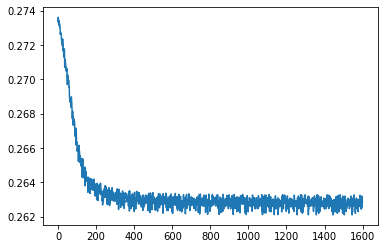

In [17]:
rng, r = random.split(rng)
model_state, opt_state, loss_values, yp = run(r, model_state, opt_state)
plt.plot(loss_values)
plt.show()

In [18]:
generative_weights

FlatMapping({
  '~': FlatMapping({
         'discount': DeviceArray(-4.59512, dtype=float32, weak_type=True),
         'temperature': DeviceArray(2.3025851, dtype=float32, weak_type=True),
       }),
})

In [19]:
model_state

FlatMapping({
  '~': FlatMapping({
         'discount': DeviceArray(-3.9833322, dtype=float32),
         'temperature': DeviceArray(2.1808138, dtype=float32),
       }),
})

## Model Evaluation
The combined model predictes the same distributions as the individually trained models from NB 7 and 8

In [20]:
rng, r = random.split(rng)
evaluate_data = batch_generate_trajectory(r, weights=model_state, batch_size=training_episode_count)
evaluate_data_flat = tree_map(np.concatenate, evaluate_data) # flatten the episodes
evaluate_data_batches = tree_batch(evaluate_data_flat, training_data_num_batches)

In [21]:
training_data.value.shape, evaluate_data.value.shape

((4096, 50), (4096, 50))

In [22]:
np.mean(training_data.value[:, 0])

DeviceArray(5.930908, dtype=float32)

In [23]:
np.mean(evaluate_data.value[:, 0])

DeviceArray(5.939453, dtype=float32)

In [24]:
render_episode(configuration, tree_index(evaluate_data.episode, 0))